<a target="_blank" rel="noopener noreferrer" href="https://colab.research.google.com/github/ccaudek/ds4psy_2023/blob/main/350_normal_normal_mod.ipynb">![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)</a>


(bayes_one_mean_notebook)=
# Inferenza bayesiana su una media

Esaminiamo ora in maggiore dettaglio un caso che abbiamo anticipato in precedenza, ovvero quello in cui disponiamo di un campione di dati a livello di scala a intervalli o rapporti e vogliamo fare inferenza sulla media della popolazione da cui il campione è stato estratto.

In [ ]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
from scipy.stats import beta
from scipy.stats import norm
import statistics
import seaborn as sns
import scipy.stats as st
import warnings

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

print(f"Running on PyMC v{pm.__version__}")

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# Initialize random number generator
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

sns.set_theme(palette="colorblind")

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "svg"

## Caso Normale-Normale con varianza nota

Supponiamo che i dati $y$ siano un campione casuale estratto da una popolazione che segue la legge Normale. Ciò significa che le osservazioni possono essere considerate come una sequenza di variabili casuali indipendenti e identicamente distribuite. Supponiamo che ciascuna v.c. segua la distribuzione Normale. Abbiamo dunque

$$
Y_1, \dots, Y_n  \stackrel{iid}{\sim} \mathcal{N}(\mu, \sigma).
$$

Abbiamo visto in un capitolo precedente che, in tali circostanze, la verosimiglianza $p(y \mid \mu, \sigma)$ è normale. Per fare inferenza sul parametro $\mu$, assumiamo che $\sigma$ sia noto e imponiamo una distribuzione a priori normale su $\mu$. Questo definisce lo *schema coniugato Normale-Normale*. In questo caso, è possibile derivare analiticamente la distribuzione a posteriori $p(\mu \mid y)$, ma la trattazione matematica è complessa e qui verrà solo accennata. Invece, impareremo ad applicare la soluzione ottenuta e mostreremo come fare inferenza su $\mu$ usando i metodi MCMC.

## Derivazione analitica della distribuzione a posteriori $p(\mu \mid y)$

Per $\sigma^2$ nota, la famiglia della distribuzione Normale è coniugata a sé stessa: se la funzione di verosimiglianza è Normale, la scelta di una distribuzione a priori Normale per $\mu$ assicura che anche la distribuzione a posteriori $p(\mu \mid y)$ sia Normale.

Poniamoci dunque il problema di trovare $p(\mu \mid y)$ nel caso di un campione casuale $Y_1, \dots, Y_n \stackrel{iid}{\sim} \mathcal{N}(\mu, \sigma)$, supponendo $\sigma$ perfettamente nota e imponendo su $\mu$ una distribuzione a priori Normale. Ricordiamo che la densità gaussiana è data da

$$
p(y_i \mid \mu, \sigma) = \frac{1}{{\sigma \sqrt {2\pi}}}\exp\left\{{-\frac{(y_i - \mu)^2}{2\sigma^2}}\right\}.
$$

Essendo le variabili i.i.d., possiamo scrivere la densità congiunta come il prodotto delle singole densità e quindi si ottiene

$$
p(y \mid \mu) = \, \prod_{i=1}^n p(y_i \mid \mu).
$$

Una volta osservati i dati $y$, la verosimiglianza diventa

$$
\begin{align}
p(y \mid \mu) =& \, \prod_{i=1}^n p(y_i \mid \mu) = \notag\\
& \frac{1}{{\sigma \sqrt {2\pi}}}\exp\left\{{-\frac{(y_1 - \mu)^2}{2\sigma^2}}\right\} \times \notag\\
 & \frac{1}{{\sigma \sqrt {2\pi}}}\exp\left\{{-\frac{(y_2 - \mu)^2}{2\sigma^2}}\right\} \times  \notag\\
& \vdots \notag\\
 & \frac{1}{{\sigma \sqrt {2\pi}}}\exp\left\{{-\frac{(y_n - \mu)^2}{2\sigma^2}}\right\}.
\end{align}
$$

Se la densità a priori $p(\mu)$ è gaussiana, allora anche la densità a posteriori $p(\mu \mid y)$ sarà gaussiana. Poniamo

$$
p(\mu) = \frac{1}{{\tau_0 \sqrt {2\pi}}}\exp\left\{{-\frac{(\mu - \mu_0)^2}{2\tau_0^2}}\right\},
$$ 

ovvero imponiamo a $\mu$ una distribuzione a priori gaussiana con media $\mu_0$ e varianza $\tau_0^2$. Ciò significa dire che, a priori, $\mu_0$ rappresenta il valore più verosimile per $\mu$, mentre $\tau_0^2$ quantifica il grado della nostra incertezza rispetto a tale valore.

Svolgendo una serie di passaggi algebrici, si arriva alla distribuzione a posteriori gaussiana

$$
p(\mu \mid y) = \frac{1}{{\tau_p \sqrt {2\pi}}}\exp\left\{{-\frac{(\mu - \mu_p)^2}{2\tau_p^2}}\right\},
$$ 

dove

$$
\mu_p = \frac{\frac{1}{\tau_0^2}\mu_0+ \frac{n}{\sigma^2}\bar{y}}{\frac {1}{\tau_0^2} + \frac{n}{\sigma^2}} 
$$

e

$$
\tau_p^2 = \frac{1}{\frac {1}{\tau_0^2}+ \frac{n}{\sigma^2}}.
$$ 

Ciò significa che, se la distribuzione a priori $p(\mu)$ è gaussiana, allora anche la distribuzione a posteriori $p(\mu \mid y)$ sarà gaussiana con valore atteso $\mu_p$ e varianza $\tau_p^2$ date dalle espressioni precedenti.

In conclusione, il risultato trovato indica che:

-   il valore atteso a posteriori è una media pesata fra il valore atteso a priori $\mu_0$ e la media campionaria $\bar{y}$; il peso della media campionaria è tanto maggiore tanto più è grande $n$ (il numero di osservazioni) e $\tau_0^2$ (l'incertezza iniziale);
-   l'incertezza (varianza) a posteriori $\tau_p^2$ è sempre più piccola dell'incertezza a priori $\tau_0^2$ e diminuisce al crescere di $n$.

Per esaminare un esempio pratico, consideriamo i 30 valori BDI-II dei soggetti clinici di {cite}`zetsche_2019future`.

In [8]:
y = [
    26.0,
    35.0,
    30,
    25,
    44,
    30,
    33,
    43,
    22,
    43,
    24,
    19,
    39,
    31,
    25,
    28,
    35,
    30,
    26,
    31,
    41,
    36,
    26,
    35,
    33,
    28,
    27,
    34,
    27,
    22,
]


<IPython.core.display.Javascript object>

Supponiamo che la varianza $\sigma^2$ della popolazione sia identica alla varianza del campione:

In [27]:
sigma = np.std(y)
sigma

6.495810615739622

Per fare un esempio, imponiamo su $\mu$ una distribuzione a priori $\mathcal{N}(25, 2)$. In tali circostanze, la distribuzione a posteriori del parametro $\mu$ può essere determinata per via analitica e corrisponde ad una Normale di media e varianza definite dall'eq. {eq}`eq-post-norm-mup` e dall'eq. {eq}`eq-post-norm-taup2`. La figura seguente mostra un grafico della distribuzione a priori, della verosimiglianza e della distribuzione a posteriori di $\mu$.

Iniziamo con la verosimiglianza.

In [28]:
def gaussian(y, m, s):
    l = np.prod(norm.pdf(y, loc=m, scale=s))
    return l

In [29]:
x_axis = np.arange(18, 38, 0.01)
s = np.std(y)
like = [gaussian(y, val, s) for val in x_axis]
l = like / np.sum(like) * 100

Usando l'eq. {eq}`eq-post-norm-mup`, definiamo una funzione che ritorna la media della distribuzione a posteriori di $\mu$.

In [ ]:
def mu_post(tau_0, mu_0, sigma, ybar, n):
    return (1 / tau_0**2 * mu_0 + n / sigma**2 * ybar) / (
        1 / tau_0**2 + n / sigma**2
    )

Troviamo la media a posteriori.

In [ ]:
mu_0 = 25  # media della distribuzione a priori per mu
tau_0 = 2  # sd della distribuzione a priori per mu
sigma = np.std(y)  # sd del campione (assunta essere sigma)
ybar = np.mean(y)  # media del campione
n = len(y)

mu_post(tau_0, mu_0, sigma, ybar, n)

Definiamo una funzione che ritorna la deviazione standard della distribuzione a posteriori di $\mu$.

In [ ]:
def tau_post(tau_0, sigma, n):
    return np.sqrt(1 / (1 / tau_0**2 + n / sigma**2))

Troviamo la deviazione standard a posteriori.

In [ ]:
tau_0 = 2  # sd della distribuzione a priori per mu
sigma = np.std(y)  # sd del campione (assunta essere sigma)
n = len(y)

tau_post(tau_0, sigma, n)

Possiamo ora disegnare la distribuzione a posteriori, insieme alla distribuzione a priori e alla verosimiglianza.

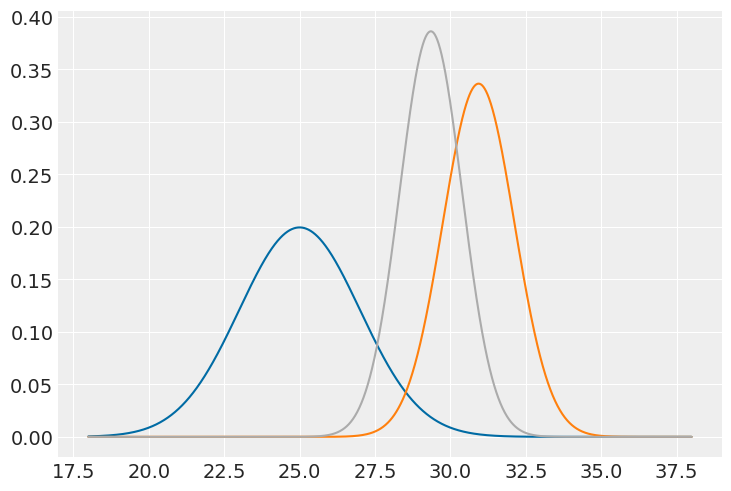

In [30]:
plt.plot(x_axis, norm.pdf(x_axis, 25, 2))
plt.plot(x_axis, l)
plt.plot(x_axis, norm.pdf(x_axis, 29.35073, 1.032919))
plt.show()

## Il modello Normale con PyMC

I priori coniugati Normali di una Normale non richiedono l'approssimazione numerica ottenuta mediante metodi MCMC. Tuttavia, per fare un esercizio e per verificare che i risultati con MCMC corrispondano a quelli trovati per via analitica, ripetiamo l'esercizio precedente usando PyMC.

### Versione 1 ($\sigma$ nota)

Come in precedenza, imponiamo su $\mu$ una distribuzione a priori $\mathcal{N}(25, 2)$ e consideriamo noto il parametro $\sigma = 6.606858$. 

Il modello diventa il seguente.

$$
\begin{align}
Y_i &\sim \mathcal{N}(\mu, \sigma) \notag\\
\mu &\sim \mathcal{N}(25, 2) \notag\\
\sigma &= 6.606858 \notag
\end{align}
$$

In base al modello così definito, la variabile casuale $Y$ seguirà la distribuzione Normale di parametri $\mu$ e $\sigma$. Il parametro $\mu$ è sconosciuto e abbiamo deciso di descrivere la nostra incertezza relativa ad esso mediante una distribuzione a priori Normale di media 25 e deviazione standard 2. Il parametro $\sigma$ è invece assunto essere noto e uguale a 6.606858. 

Definiamo questo modello usando la sintassi PyMC.

In [3]:
gauss_model = pm.Model()

with gauss_model:

    # Priors
    mu = pm.Normal("mu", mu=25, sigma=2)

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=6.606858, observed=y)

Eseguiamo il campionamento MCMC.

In [4]:
with gauss_model:
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


Una sintesi della distribuzione a posteriori dei parametri si ottiene nel modo seguente.

In [5]:
az.summary(idata, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,29.36,1.04,27.41,31.3,0.03,0.02,1730.31,2643.65,1.0


Si noti che le stime ottenute corrispondono ai valori teorici attesi, ovvero $\mu_p$ = 29.36 contro un valore teorico di 29.3898 e $\tau_p$ = 1.04 contro un valore teorico di 1.0201.

Esaminiamo la traccia (cioè il vettore dei campioni del parametro $\mu$ prodotti dalla procedura di campionamento MCMC) mediante un *trace plot* .

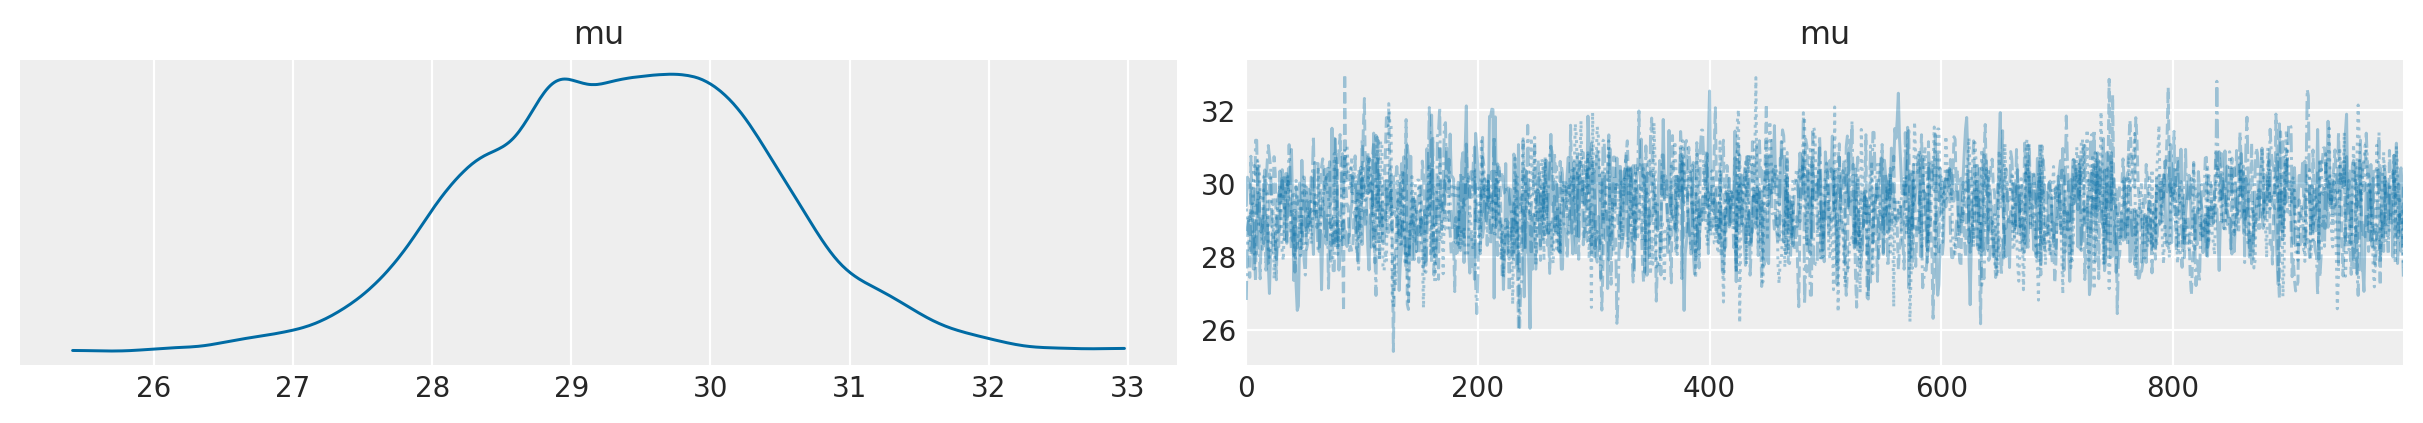

In [6]:
az.plot_trace(idata, combined=True)
plt.show()

Calcoliamo l'intervallo di credibilità a più alta densità a posteriori (HPD) al 95%.

In [7]:
az.hdi(idata, hdi_prob=0.95)

<xarray.Dataset>
Dimensions:  (hdi: 2)
Coordinates:
  * hdi      (hdi) <U6 'lower' 'higher'
Data variables:
    mu       (hdi) float64 27.38 31.42

Le stime così trovate sono molto simili ai quantili di ordine 0.025 e 0.975 della distribuzione a posteriori di $\mu$ ottenuta per via analitica.

In [8]:
norm.ppf([0.025, 0.975], loc=29.35073, scale=1.032919)

array([27.32624596, 31.37521404])


### Versione 2 ($\sigma$ incognita)

È facile estendere il caso precedente alla situazione in cui il parametro $\sigma$ è incognito. Se non conosciamo $\sigma$, è necessario imporre su tale parametro una distribuzione a priori. Supponiamo di ipotizzare per $\sigma$ una distribuzione a priori $Cauchy(0, 15)$.

Mediante una Cauchy(0, 15) descriviamo il grado di credibilità soggettiva che attribuiamo ai possibili valori (\> 0) del parametro $\sigma$. Ai valori prossimi allo 0 attribuiamo la credibilità maggiore; la credibilità dei valori $\sigma > 0$ diminuisce progressivamente quando ci si allontana dallo 0, come indicato dalla curva della figura seguente. Riteniamo poco credibili i valori $\sigma$ maggiori di 40, anche se non escludiamo completamente che $\sigma$ possa assumere un valore in questo intervallo.

La Cauchy(0, 15) è rappresentata nella figura seguente.

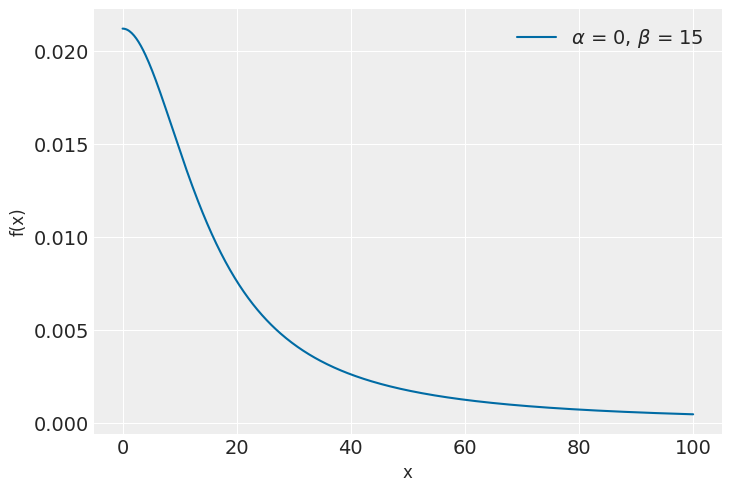

In [41]:
x = np.linspace(0, 100, 500)
alpha = 0
beta = 15
pdf = st.cauchy.pdf(x, loc=alpha, scale=beta)
plt.plot(x, pdf, label=r"$\alpha$ = {}, $\beta$ = {}".format(alpha, beta))
plt.xlabel("x", fontsize=12)
plt.ylabel("f(x)", fontsize=12)
plt.legend(loc=1)
plt.show()


In questo secondo caso, più realistico, il modello diventa il seguente.

$$
\begin{align}
Y_i &\sim \mathcal{N}(\mu, \sigma) \notag\\
\mu &\sim \mathcal{N}(25, 2) \notag\\
\sigma &\sim Cauchy(0, 15) \notag
\end{align}
$$

Il modello precedente è simile a quello esaminato in precedenza, eccetto che abbiamo quantificato la nostra incertezza relativa a $\sigma$ (che è ignota) mediante una distribuzione a priori Cauchy(0, 15).

Il campionamento MCMC utilizzato di default da PyMC è basata sull'algoritmo NUTS che è una variante del metodo Hybrid/Hamiltonian Monte Carlo. Tale algoritmo ha il vantaggio di massimizzare l'accettanza e di non richiedere l'uso di distribuzioni a priori coniugate. Pertanto è possibile scegliere per i parametri una qualunque distribuzione a priori. Nel caso presente, sul parametro $\sigma$ abbiamo imposto una Cauchy(0, 15). Per un tale caso non è possibile ottenere la derivazione analitica della distribuzione a posteriori di $\mu$. È dunque necessario procedere con il campionamento MCMC.

Scriviamo il modello in PyMC.

In [42]:
gauss2_model = pm.Model()

with gauss2_model:

    # Priors
    mu = pm.Normal("mu", mu=25, sigma=2)
    sigma = pm.Cauchy("sigma", alpha=0, beta=15)

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=y)

Eseguiamo il campionamento.

In [43]:
with gauss2_model:
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


Una sintesi della distribuzione a posteriori dei parametri si ottiene nel modo seguente.

In [44]:
az.summary(idata, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,29.21,1.17,27.06,31.40,0.03,0.02,2044.34,2356.70,1.0
sigma,7.06,1.01,5.31,8.96,0.02,0.02,2397.96,2083.34,1.0


Troviamo l'intervallo di credibilità a più alta densità a posteriori (HPD) al 95%.

In [45]:
az.hdi(idata, hdi_prob=0.95)

<xarray.Dataset>
Dimensions:  (hdi: 2)
Coordinates:
  * hdi      (hdi) <U6 'lower' 'higher'
Data variables:
    mu       (hdi) float64 26.87 31.4
    sigma    (hdi) float64 5.291 9.108

Esaminiamo la traccia con un *trace plot* .

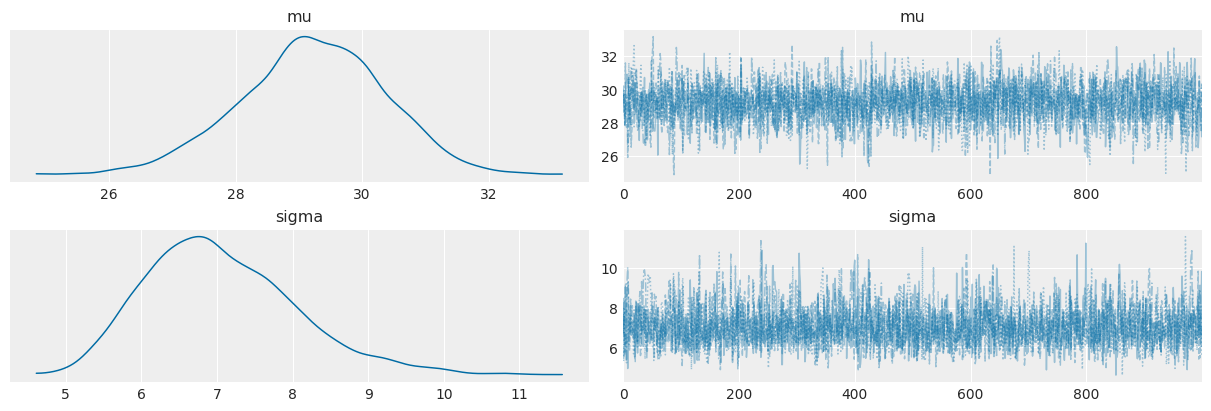

In [46]:
az.plot_trace(idata, combined=True)

Considerati i dati osservati e le nostre ipotesi a priori sui parametri, possiamo concludere, con un grado di certezza soggettiva del 95%, che la media della popolazione dei punteggi BDI-II dei pazienti clinici depressi è compresa nell'intervallo \[27.04, 31.33\].

## Commenti e considerazioni finali

In questo capitolo abbiamo visto come calcolare l'intervallo di credibilità per la media di una v.c. Normale. La domanda più ovvia di analisi dei dati, dopo avere visto come trovare l'intervallo di credibilità per la media di un solo gruppo, riguarda il confronto tra le medie di due gruppi. Questo sarà l'argomento discusso nei prossimi capitoli.

## Watermark

In [47]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor

Last updated: Mon Dec 26 2022

Python implementation: CPython
Python version       : 3.8.15
IPython version      : 8.7.0

pytensor: 2.8.10

sys       : 3.8.15 (default, Nov 24 2022, 09:04:07) 
[Clang 14.0.6 ]
scipy     : 1.9.3
pymc      : 5.0.0
numpy     : 1.24.0
matplotlib: 3.6.2
arviz     : 0.14.0
pandas    : 1.5.2

Watermark: 2.3.1

